In [7]:
from langchain import hub
from langchain.schema import StrOutputParser, Document
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import ParentDocumentRetriever
from langchain.vectorstores import FAISS
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain_ollama import OllamaLLM
from langchain.embeddings import HuggingFaceBgeEmbeddings
from concurrent.futures import ThreadPoolExecutor
from langchain.document_loaders.base import BaseLoader
from langchain.docstore.document import Document
from typing import List, Optional
from functools import lru_cache
from langchain.storage import InMemoryStore
import time
import re
import os
import pandas as pd
import seaborn as sns

## PMAPI Y COBERTURA

In [36]:
df = pd.read_excel('exps 6-9/Experimento_9.xlsx', engine='openpyxl')
primeras_9 = df.iloc[:9]
filas_13_14 = df.iloc[[12, 13]]
df_inicial = pd.concat([primeras_9, filas_13_14])
df_inicial.reset_index(drop=True, inplace=True)
df_inicial_PMAPI=df_inicial[["Consulta", "Campo que se quiere extraer (PMAPI)"]]

df_llm_español = pd.read_excel('exps 6-9/evaluacion_español_9.xlsx', engine='openpyxl')
df_llm_español=df_llm_español[["Consulta", "Puntuación_coverage"]]

df_llm_ingles = pd.read_excel('exps 6-9/evaluacion_ingles_coherencia_9.xlsx', engine='openpyxl')
df_llm_ingles=df_llm_ingles[["Consulta", "Puntuación_coverage"]]

df_llm_ingles_1_3 = pd.read_excel('exps 6-9/evaluacion_1_3_ingles_coherencia_9.xlsx', engine='openpyxl')
df_llm_ingles=df_llm_ingles_1_3[["Consulta", "Puntuación_coverage"]]

In [37]:
df_llm_cobertura = pd.DataFrame()
df_llm_cobertura = df_inicial_PMAPI  

df_llm_cobertura = df_inicial_PMAPI.copy()
df_llm_cobertura["Puntuación_coverage_100_ingles"] = ((df_llm_ingles["Puntuación_coverage"] - 1) / 4) * 100
df_llm_cobertura["Puntuación_coverage_100_español"] = ((df_llm_español["Puntuación_coverage"] - 1) / 4) * 100
df_llm_cobertura["Puntuación_coverage_100_ingles_1_3"] = ((df_llm_ingles_1_3["Puntuación_coverage"] - 1) / 2) * 100

In [38]:
print(df_llm_cobertura)

                                             Consulta  \
0   What is the objective of the project with gran...   
1   What is the total cost of the project with the...   
2   How much funding was allocated for the project...   
3   Which organisation played the role of coordina...   
4   What topic does the project with the acronym I...   
5   What legal basis was the project titled Europe...   
6   What type of proposal was the grant agreement ...   
7   To which master call was the project with the ...   
8   To which sub call was the project titled Elect...   
9   Provide the objective of 1 project related to ...   
10  Provide the objective of 3 different projects ...   

    Campo que se quiere extraer (PMAPI)  Puntuación_coverage_100_ingles  \
0                                  50.0                            50.0   
1                                 100.0                            25.0   
2                                 100.0                             0.0   
3              

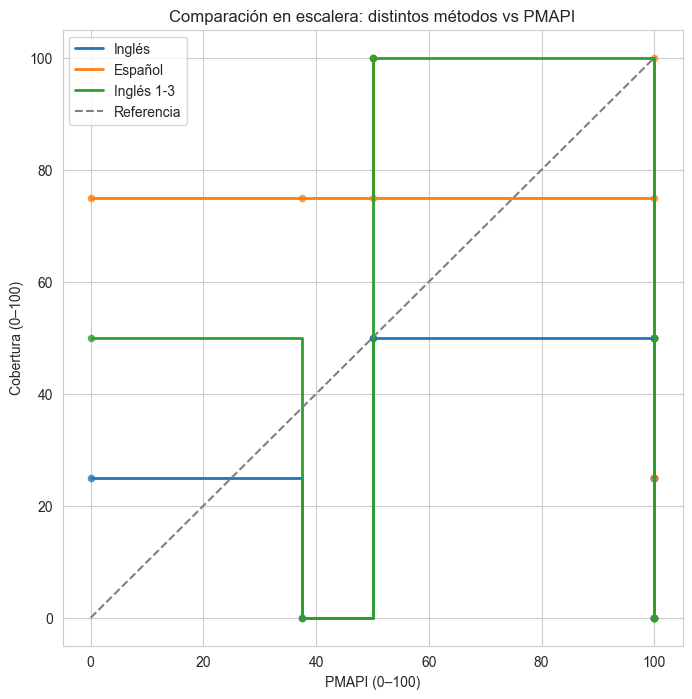

In [40]:
import matplotlib.pyplot as plt

cols = [
    ("Puntuación_coverage_100_ingles", "Inglés"),
    ("Puntuación_coverage_100_español", "Español"),
    ("Puntuación_coverage_100_ingles_1_3", "Inglés 1-3")
]

plt.figure(figsize=(8, 8))

df_sorted = df_llm_cobertura.sort_values(by="Campo que se quiere extraer (PMAPI)")

for col, nombre in cols:
    plt.step(df_sorted["Campo que se quiere extraer (PMAPI)"],
             df_sorted[col],
             where="post", linewidth=2, label=nombre)
    
    
    plt.scatter(df_sorted["Campo que se quiere extraer (PMAPI)"],
                df_sorted[col],
                s=20, alpha=0.7) 

plt.plot([0,100], [0,100], linestyle="--", color="gray", label="Referencia")

plt.xlabel("PMAPI (0–100)")
plt.ylabel("Cobertura (0–100)")
plt.title("Comparación en escalera: distintos métodos vs PMAPI")
plt.legend()
plt.grid(True)
plt.show()


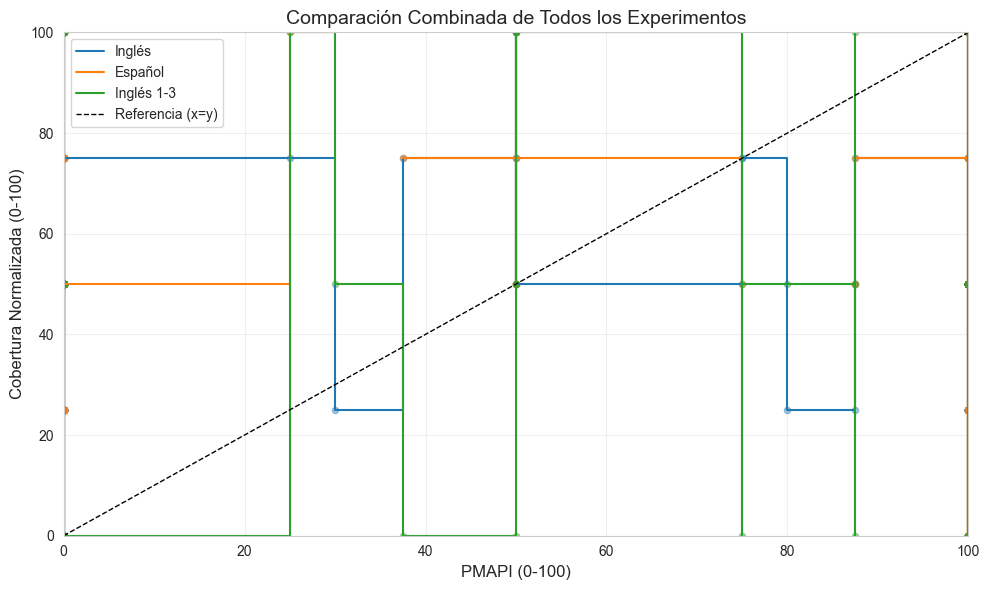

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

categorias = {
    'Inglés': {'archivo': 'evaluacion_ingles_coherencia_{}.xlsx', 'escala': (1, 5)},
    'Español': {'archivo': 'evaluacion_español_{}.xlsx', 'escala': (1, 5)},
    'Inglés 1-3': {'archivo': 'evaluacion_1_3_ingles_coherencia_{}.xlsx', 'escala': (1, 3)}
}

df_combinado = pd.DataFrame()

for exp_num in range(2, 14): 
    try:

        df_pmapi = pd.read_excel(f'Desiree/Experimento_{exp_num}.xlsx', engine='openpyxl')
        df_pmapi = pd.concat([df_pmapi.iloc[:9], df_pmapi.iloc[[12, 13]]])
        df_pmapi = df_pmapi[["Consulta", "Campo que se quiere extraer (PMAPI)"]].reset_index(drop=True)
        
        for nombre, config in categorias.items():
            df_eval = pd.read_excel(f'Desiree/{config["archivo"].format(exp_num)}', engine='openpyxl')
            df_eval = df_eval[["Consulta", "Puntuación_coverage"]]
            
            min_scale, max_scale = config["escala"]
            df_eval[f'Puntuación_{nombre}'] = ((df_eval["Puntuación_coverage"] - min_scale) / (max_scale - min_scale)) * 100
            
        
            if nombre == 'Inglés':
                df_temp = df_pmapi.copy()
            df_temp[f'Puntuación_{nombre}'] = df_eval[f'Puntuación_{nombre}']
        
        
        df_temp['Experimento'] = exp_num
        df_combinado = pd.concat([df_combinado, df_temp])
        
    except FileNotFoundError:
        print(f"Advertencia: Archivos no encontrados para experimento {exp_num}")
        continue

df_combinado = df_combinado.sort_values(by="Campo que se quiere extraer (PMAPI)")

plt.figure(figsize=(10, 6))

colors = {'Inglés': '#1f77b4', 'Español': '#ff7f0e', 'Inglés 1-3': '#2ca02c'}

for nombre in categorias.keys():
    plt.step(df_combinado["Campo que se quiere extraer (PMAPI)"],
             df_combinado[f'Puntuación_{nombre}'],
             where="post",
             linewidth=1.5,
             color=colors[nombre],
             label=nombre)
    
    plt.scatter(df_combinado["Campo que se quiere extraer (PMAPI)"],
                df_combinado[f'Puntuación_{nombre}'],
                s=20,
                alpha=0.4,
                color=colors[nombre])

plt.plot([0,100], [0,100], 'k--', label="Referencia (x=y)", linewidth=1)

plt.xlabel("PMAPI (0-100)", fontsize=12)
plt.ylabel("Cobertura Normalizada (0-100)", fontsize=12)
plt.title("Comparación Combinada de Todos los Experimentos", fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 100)
plt.ylim(0, 100)

plt.tight_layout()
plt.savefig('comparacion_combinada.png', dpi=300)
plt.show()

## Coherencia (binario) y fluidez

## ESPAÑOL

In [8]:
todos_datos = []

for i in range(2, 14): 
    df = pd.read_excel(f'Desiree/Experimento_{i}.xlsx', engine='openpyxl')
    primeras_9 = df.iloc[:9]
    filas_13_14 = df.iloc[[12, 13]]
    df_inicial = pd.concat([primeras_9, filas_13_14]).reset_index(drop=True)

    df_llm = pd.read_excel(f'Desiree/evaluacion_español_{i}.xlsx', engine='openpyxl')
    df_llm = df_llm[["Consulta", "Puntuación_faithfulness", "Puntuación"]]

    df_binario = df_inicial[["Consulta", "Veracidad parcial", "Veracidad total"]]

    df_combinado = df_binario.merge(df_llm, on="Consulta", how="inner")

    df_combinado = df_combinado.rename(columns={
        "Veracidad parcial": f"Veracidad parcial Exp{i}",
        "Veracidad total": f"Veracidad total Exp{i}",
        "Puntuación_faithfulness": f"Faithfulness Exp{i}",
        "Puntuación": f"Puntuación Exp{i}"
    })

    todos_datos.append(df_combinado)

df_final = todos_datos[0]
for df_temp in todos_datos[1:]:
    df_final = df_final.merge(df_temp, on="Consulta", how="outer")

print(df_final)

                                             Consulta  Veracidad parcial Exp2  \
0   How much funding was allocated for the project...                     1.0   
1   Provide the objective of 1 project related to ...                     1.0   
2   Provide the objective of 3 different projects ...                     1.0   
3   To which master call was the project with the ...                     1.0   
4   To which sub call was the project titled Elect...                     1.0   
5   What is the objective of the project with gran...                     0.0   
6   What is the total cost of the project with the...                     1.0   
7   What legal basis was the project titled Europe...                     NaN   
8   What topic does the project with the acronym I...                     0.0   
9   What type of proposal was the grant agreement ...                     0.0   
10  Which organisation played the role of coordina...                     1.0   

    Veracidad total Exp2  F

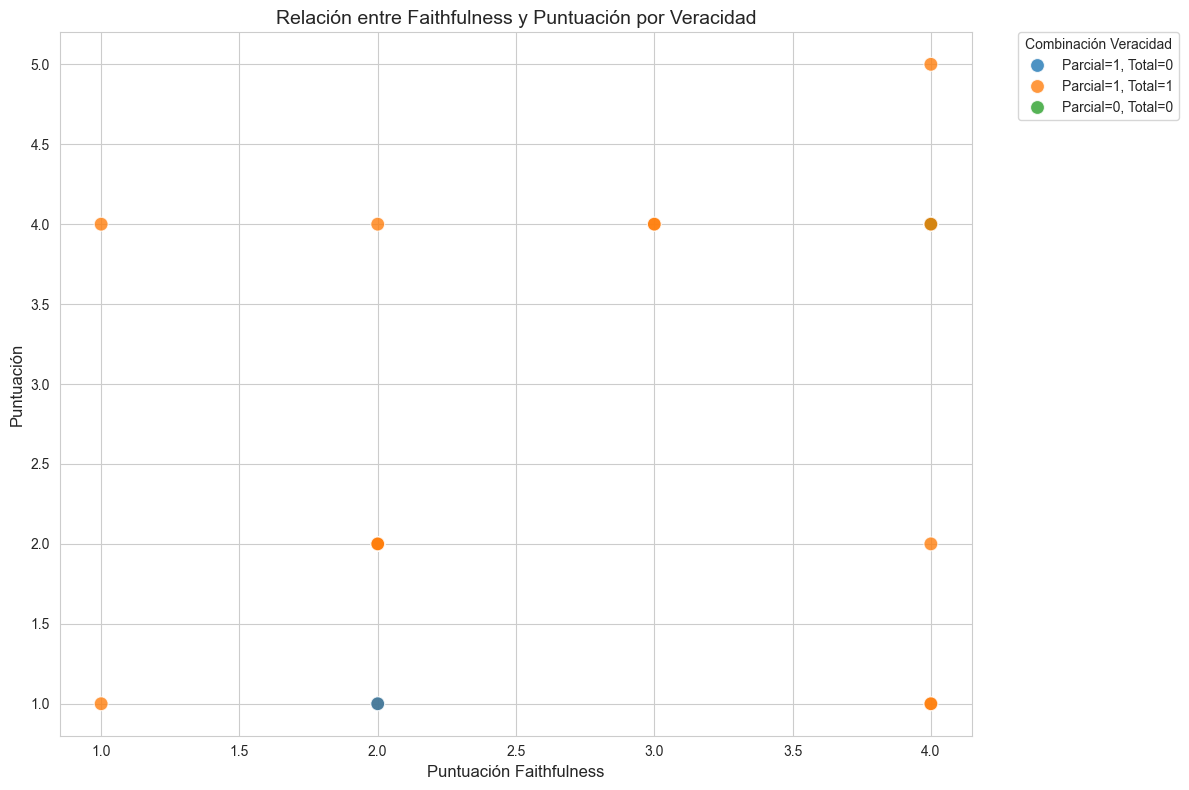

In [9]:
datos_reorganizados = []

for i in range(3):
    exp_num = i + 7
    temp_df = pd.DataFrame({
        'Consulta': df_final['Consulta'],
        'Faithfulness': df_final[f'Faithfulness Exp{exp_num}'],
        'Puntuación': df_final[f'Puntuación Exp{exp_num}'],
        'Veracidad Parcial': df_final[f'Veracidad parcial Exp{exp_num}'],
        'Veracidad Total': df_final[f'Veracidad total Exp{exp_num}'],
        'Experimento': f'Exp {exp_num}'
    })
    
    temp_df = temp_df.dropna()
    
    temp_df['Veracidad'] = temp_df.apply(
        lambda x: f"Parcial={int(x['Veracidad Parcial'])}, Total={int(x['Veracidad Total'])}", 
        axis=1
    )
    
    datos_reorganizados.append(temp_df)

df_plot = pd.concat(datos_reorganizados, ignore_index=True)


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_plot,
    x='Faithfulness',
    y='Puntuación',
    hue='Veracidad', 
    palette='tab10', 
    s=100,
    alpha=0.8
)

plt.title('Relación entre Faithfulness y Puntuación por Veracidad', fontsize=14)
plt.xlabel('Puntuación Faithfulness', fontsize=12)
plt.ylabel('Puntuación', fontsize=12)

plt.legend(
    title='Combinación Veracidad',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()

plt.show()

## Ingles

In [17]:
todos_datos = []

for i in range(2, 14): 
    df = pd.read_excel(f'Desiree/Experimento_{i}.xlsx', engine='openpyxl')
    primeras_9 = df.iloc[:9]
    filas_13_14 = df.iloc[[12, 13]]
    df_inicial = pd.concat([primeras_9, filas_13_14]).reset_index(drop=True)

    df_llm = pd.read_excel(f'Desiree/evaluacion_ingles_coherencia_{i}.xlsx', engine='openpyxl')
    df_llm = df_llm[["Consulta", "Puntuación_faithfulness", "Puntuación"]]

    df_binario = df_inicial[["Consulta", "Veracidad parcial", "Veracidad total"]]

    df_combinado = df_binario.merge(df_llm, on="Consulta", how="inner")

    df_combinado = df_combinado.rename(columns={
        "Veracidad parcial": f"Veracidad parcial Exp{i}",
        "Veracidad total": f"Veracidad total Exp{i}",
        "Puntuación_faithfulness": f"Faithfulness Exp{i}",
        "Puntuación": f"Puntuación Exp{i}"
    })

    todos_datos.append(df_combinado)

df_final = todos_datos[0]
for df_temp in todos_datos[1:]:
    df_final = df_final.merge(df_temp, on="Consulta", how="outer")

print(df_final)

                                             Consulta  Veracidad parcial Exp2  \
0   How much funding was allocated for the project...                     1.0   
1   Provide the objective of 1 project related to ...                     1.0   
2   Provide the objective of 3 different projects ...                     1.0   
3   To which master call was the project with the ...                     1.0   
4   To which sub call was the project titled Elect...                     1.0   
5   What is the objective of the project with gran...                     0.0   
6   What is the total cost of the project with the...                     1.0   
7   What legal basis was the project titled Europe...                     NaN   
8   What topic does the project with the acronym I...                     0.0   
9   What type of proposal was the grant agreement ...                     0.0   
10  Which organisation played the role of coordina...                     1.0   

    Veracidad total Exp2  F

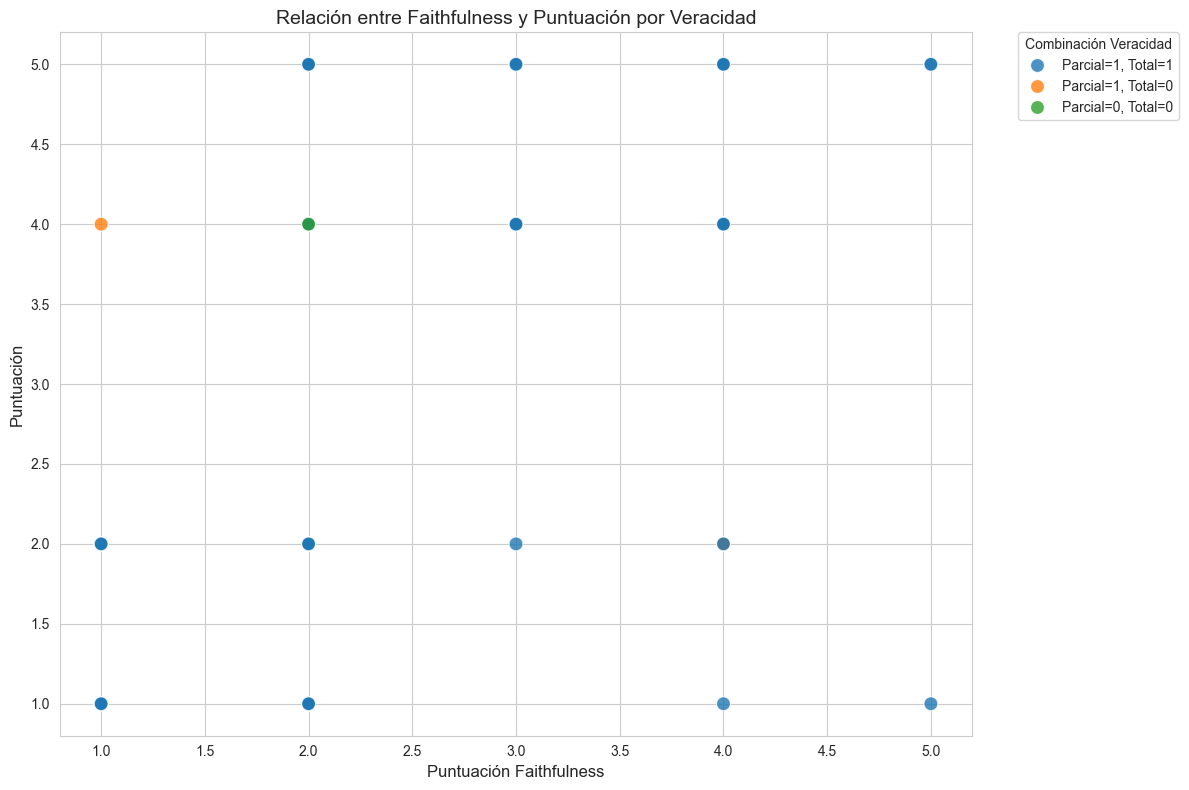

In [18]:
datos_reorganizados = []

for exp_num in range(2, 14):
    temp_df = pd.DataFrame({
        'Consulta': df_final['Consulta'],
        'Faithfulness': df_final[f'Faithfulness Exp{exp_num}'],
        'Puntuación': df_final[f'Puntuación Exp{exp_num}'],
        'Veracidad Parcial': df_final[f'Veracidad parcial Exp{exp_num}'],
        'Veracidad Total': df_final[f'Veracidad total Exp{exp_num}'],
        'Experimento': f'Exp {exp_num}'
    })
    
    temp_df = temp_df.dropna()
    
    temp_df['Veracidad'] = temp_df.apply(
        lambda x: f"Parcial={int(x['Veracidad Parcial'])}, Total={int(x['Veracidad Total'])}", 
        axis=1
    )
    
    datos_reorganizados.append(temp_df)

df_plot = pd.concat(datos_reorganizados, ignore_index=True)


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_plot,
    x='Faithfulness',
    y='Puntuación',
    hue='Veracidad', 
    palette='tab10', 
    s=100,
    alpha=0.8
)

plt.title('Relación entre Faithfulness y Puntuación por Veracidad', fontsize=14)
plt.xlabel('Puntuación Faithfulness', fontsize=12)
plt.ylabel('Puntuación', fontsize=12)

plt.legend(
    title='Combinación Veracidad',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()

plt.show()

## Ingles 1-3

In [20]:
todos_datos = []
 
for i in range(2, 14): 
    df = pd.read_excel(f'Desiree/Experimento_{i}.xlsx', engine='openpyxl')
    primeras_9 = df.iloc[:9]
    filas_13_14 = df.iloc[[12, 13]]
    df_inicial = pd.concat([primeras_9, filas_13_14]).reset_index(drop=True)

    df_llm = pd.read_excel(f'Desiree/evaluacion_1_3_ingles_coherencia_{i}.xlsx', engine='openpyxl')
    df_llm = df_llm[["Consulta", "Puntuación_faithfulness", "Puntuación"]]

    df_binario = df_inicial[["Consulta", "Veracidad parcial", "Veracidad total"]]

    df_combinado = df_binario.merge(df_llm, on="Consulta", how="inner")

    df_combinado = df_combinado.rename(columns={
        "Veracidad parcial": f"Veracidad parcial Exp{i}",
        "Veracidad total": f"Veracidad total Exp{i}",
        "Puntuación_faithfulness": f"Faithfulness Exp{i}",
        "Puntuación": f"Puntuación Exp{i}"
    })

    todos_datos.append(df_combinado)

df_final = todos_datos[0]
for df_temp in todos_datos[1:]:
    df_final = df_final.merge(df_temp, on="Consulta", how="outer")

print(df_final)

                                             Consulta  Veracidad parcial Exp2  \
0   How much funding was allocated for the project...                     1.0   
1   Provide the objective of 1 project related to ...                     1.0   
2   Provide the objective of 3 different projects ...                     1.0   
3   To which master call was the project with the ...                     1.0   
4   To which sub call was the project titled Elect...                     1.0   
5   What is the objective of the project with gran...                     0.0   
6   What is the total cost of the project with the...                     1.0   
7   What legal basis was the project titled Europe...                     NaN   
8   What topic does the project with the acronym I...                     0.0   
9   What type of proposal was the grant agreement ...                     0.0   
10  Which organisation played the role of coordina...                     1.0   

    Veracidad total Exp2  F

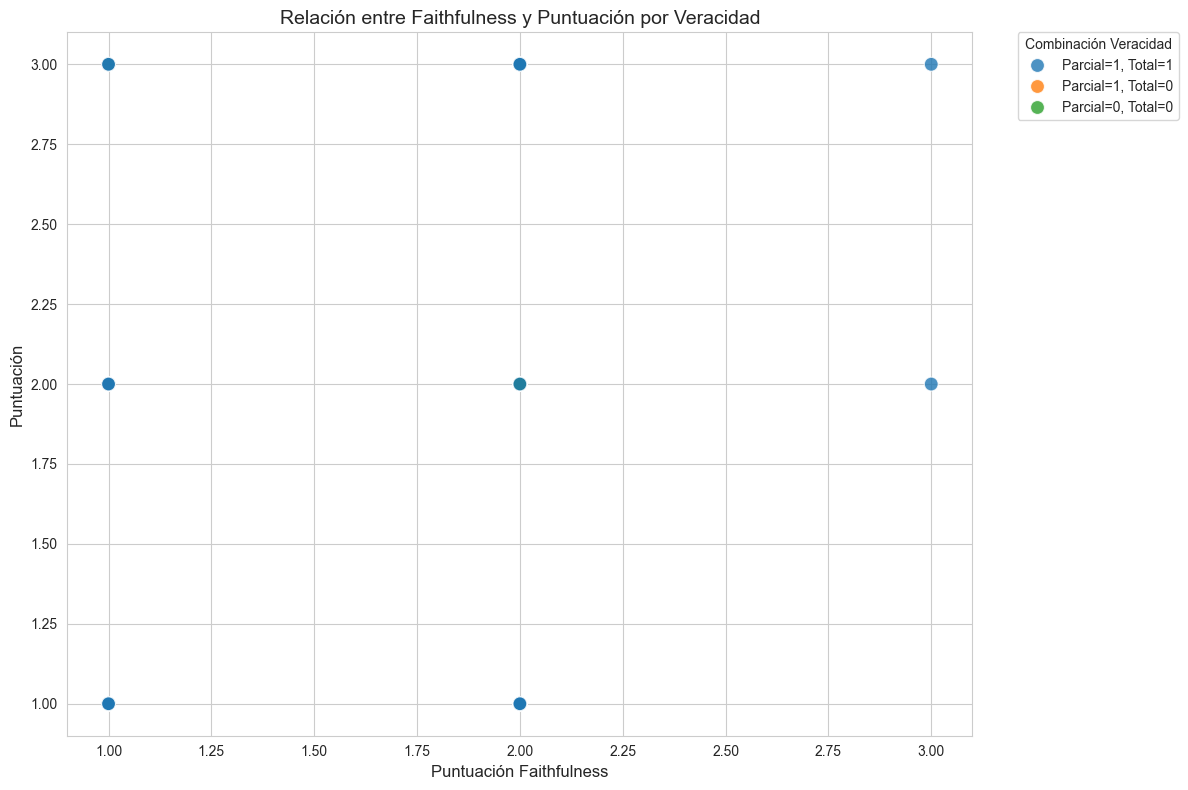

In [22]:
datos_reorganizados = []

for exp_num in range(2, 14):
    temp_df = pd.DataFrame({
        'Consulta': df_final['Consulta'],
        'Faithfulness': df_final[f'Faithfulness Exp{exp_num}'],
        'Puntuación': df_final[f'Puntuación Exp{exp_num}'],
        'Veracidad Parcial': df_final[f'Veracidad parcial Exp{exp_num}'],
        'Veracidad Total': df_final[f'Veracidad total Exp{exp_num}'],
        'Experimento': f'Exp {exp_num}'
    })
    
    temp_df = temp_df.dropna()
    
    temp_df['Veracidad'] = temp_df.apply(
        lambda x: f"Parcial={int(x['Veracidad Parcial'])}, Total={int(x['Veracidad Total'])}", 
        axis=1
    )
    
    datos_reorganizados.append(temp_df)

df_plot = pd.concat(datos_reorganizados, ignore_index=True)


plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

scatter = sns.scatterplot(
    data=df_plot,
    x='Faithfulness',
    y='Puntuación',
    hue='Veracidad', 
    palette='tab10', 
    s=100,
    alpha=0.8
)

plt.title('Relación entre Faithfulness y Puntuación por Veracidad', fontsize=14)
plt.xlabel('Puntuación Faithfulness', fontsize=12)
plt.ylabel('Puntuación', fontsize=12)

plt.legend(
    title='Combinación Veracidad',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()

plt.show()